In [3]:
import numpy as np
import pandas as pd
from numpy import linalg
import matplotlib.pyplot as plt


### Part 1 Principal Component Analysis on MNIST

In [4]:
data = pd.read_csv('MNIST2class.csv',header = None, index_col = False)


In [5]:
class pca_analysis(object):
    
    def __init__(self, data):

        # Get only data points for specified class label
        df = data #data.loc[data[0] == class_label]

        # Convert to np array with feature labels in first row
        self.array = df.to_numpy().T

        # Features (M,N) matrix where each column is the feature col
        self.features = self.array[1:,:]
        
    def solve(self):

        # Calculate mean along each row
        self.mean_vec = self.features.mean(axis = 1)

        # Total Samples
        N = self.mean_vec.shape[0]

        # Reshape mean_vector to be column_vector
        self.mean_vec = self.mean_vec.reshape(N,1)

        # Scatter Matrix
        self.S = (1/N)*np.matmul((self.features-self.mean_vec),(self.features-self.mean_vec).transpose())

        # Find eigenvalue w and eigenvector v
        self.w, self.v = linalg.eig(self.S) # This is sort already from larest to smallest left to right
        
        # Sort smallest to largest to find index of max eigenvalue
        sorted_index = np.argsort(np.real(self.w))
        
        return self.mean_vec, self.w, self.v, sorted_index
    
    def proj(self):
        
        proj_score = np.matmul(self.v.transpose(),(self.features - self.mean_vec))
        
        return proj_score

    


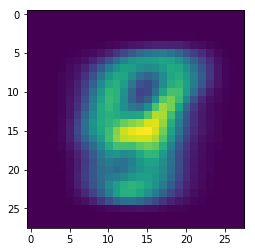

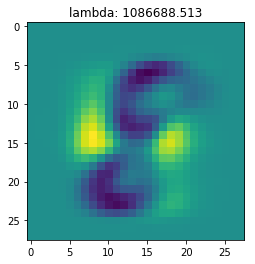

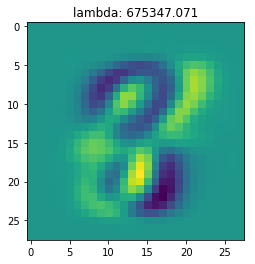

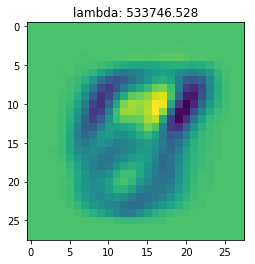

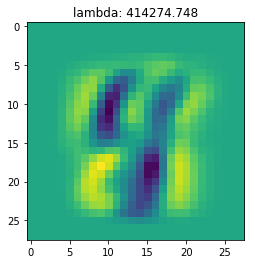

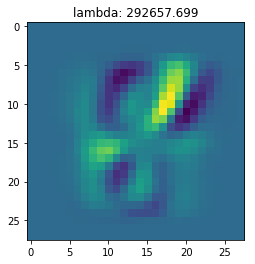

In [6]:
pca = pca_analysis(data)
mean_vec, w, v, sorted_index = pca.solve()

score = pca.proj()
score.shape
components = 5

mean_img = mean_vec.reshape(28,28)
plt.figure()
plt.imshow(mean_img)

for component_num in range(1,components+1):

    index = sorted_index[-component_num]
    
    pca_img = np.real(v[:,index]).reshape(28,28)
    plt.figure()
    plt.imshow(pca_img)
    value = np.real(w[index]).round(3)
    plt.title('lambda: ' + str(value))


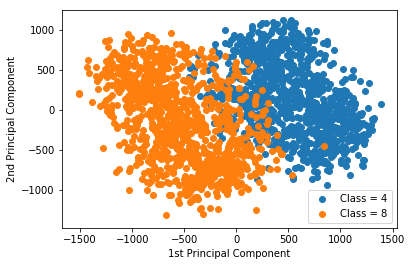

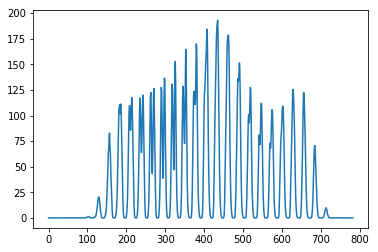

In [38]:
plt.figure()
plt.scatter(np.real(score[0,:1000]),np.real(score[1,:1000]),label='Class = 4')
plt.scatter(np.real(score[0,1000:]),np.real(score[1,1000:]), label = 'Class = 8')
plt.legend()
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')


### Part 2 Fisher’s Linear Discriminant (FLD)

In [7]:
# FLD Fisher's Linear Discriminant 

# Class 1 import data
fldC1_df = pd.read_csv('fldC1.csv', header = None, index_col = False)

# Class 2 import data
fldC2_df = pd.read_csv('fldC2.csv', header = None, index_col = False)

In [8]:
# Data is (N,M) Matrix
c1 = fldC1_df.to_numpy()
c2 = fldC2_df.to_numpy()

# number of subsets to split data to
k_folds = 5
    

# initial test set
k = 0

# Number of samples
N1 = c1.shape[0]
N2 = c2.shape[0]

# Total samples
N = N1 + N2

# Total classes
classes = 2

# init list to store subsets
subset_c1 = []
subset_c2 = []

# subsets size based on number of classes
subset_size = int(N/(k_folds * classes))

# test set size
test_size = int(N/(k_folds))

# Seperate data into subsets
while k < k_folds:

    index_start = int(k * subset_size)
    index_end = int((k+1) * subset_size)

    subset_c1.append(c1[index_start:index_end])
    subset_c2.append(c2[index_start:index_end])

    k += 1

# Convery subset list to array
subset_c1 = np.array(subset_c1)
subset_c2 = np.array(subset_c2)

# init list to store accuracy of classifier
accuracy_list = []

# iterate through each test set
for i in range(0,5):

    # indices for seperating training and test set
    set_list = list(range(0,5))

    # remove test set index from list of subset indicies
    del set_list[i]

    # set training and test set for class 1
    test_c1 = subset_c1[i]
    test_c1 = np.append(test_c1,np.ones((subset_size,1)),axis = 1)
    train_c1 = subset_c1[set_list]
    
    # set training and test set for class 2
    test_c2 = subset_c2[i]
    test_c2 = np.append(test_c2,2*np.ones((subset_size,1)),axis = 1)        
    train_c2 = subset_c2[set_list]

    # Combine Test sets
    test_set = np.concatenate([test_c1,test_c2],axis = 0)

    # seperate features vector and labels
    test = test_set[:,:2].transpose()
    test_labels = test_set[:,2].transpose()

    # Combine subsets to create training set
    train_c1 = np.concatenate([train_c1[0],train_c1[1],train_c1[2],train_c1[3]], axis = 0)
    train_c2 = np.concatenate([train_c2[0],train_c2[1],train_c2[2],train_c2[3]], axis = 0)

    # Transpose to (M,N) vector
    train_c1 = train_c1.transpose()
    train_c2 = train_c2.transpose()
    
    # Calculate mean of each class
    m1 = train_c1.mean(axis = 1).reshape(2,1)
    m2 = train_c2.mean(axis = 1).reshape(2,1)

    # Calculate mean for each feature from both classes
    m = (1/N)*(N1*m1 + N2*m2).sum(axis = 1).reshape(2,1)

    # Calculate Scatter Matrix for each class
    S1 = np.matmul((train_c1 - m1),(train_c1-m1).transpose())
    S2 = np.matmul((train_c2 - m2),(train_c2-m2).transpose())

    # Calculate class scatter matrix
    Sw = S1 + S2

    # Calculate between class scatter matrix
    SB = np.matmul((m1 - m2),(m1-m2).transpose())

    # Calulcate (Sw^-1)(SB)
    S = np.matmul(linalg.inv(Sw),SB)

    # Calculate eigenvector and eigenvalues for S
    w,v = linalg.eig(S)

    # Get eigenvector with the max eigenvalue
    sorted_index = np.argsort(w)
    arg_max_index = sorted_index[-1]

    param = v[:,arg_max_index].reshape(2,1)

    # Project data onto 1-D space
    yProj = np.matmul(param.transpose(),(test - m))

    # Classification Rule
    yProj[yProj>0] = 1
    yProj[yProj<0] = 2

    accuracy = (yProj == test_labels).sum()/test_size

    accuracy_list.append(accuracy)

    print('Test Set {:} Accuracy: {:.2%}'.format(i+1,accuracy))

print('Average Accuracy: {:.2%}'.format(np.mean(accuracy_list)))

Test Set 1 Accuracy: 95.50%
Test Set 2 Accuracy: 96.50%
Test Set 3 Accuracy: 95.75%
Test Set 4 Accuracy: 95.75%
Test Set 5 Accuracy: 96.00%
Average Accuracy: 95.90%


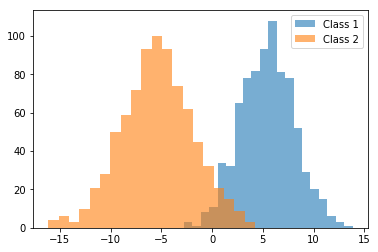

In [13]:
proj_c1 = np.matmul(param.transpose(),(train_c1 - m)).reshape(800,1)
proj_c2 = np.matmul(param.transpose(),(train_c2 - m)).reshape(800,1)

plt.hist(proj_c1,bins = 20,alpha= 0.6,label = 'Class 1')
plt.hist(proj_c2,bins = 20,alpha = 0.6,label = 'Class 2')
plt.legend()
plt.show()
